# Interchangeability between raster and vector representations

This tutorial, showcases the following:
1. Vectorization, i.e. the convertion of labels into shapes
2. Rasterization, i.e. the convertion of shapes (or points) into labels
3. Rasterization of binned data, i.e. a performant lazy conversion of shapes (or points) representing grid-like bins into multi-channel images

In [1]:
%load_ext jupyter_black

In [2]:
import spatialdata_plot
from spatialdata import rasterize, to_circles, to_polygons
from spatialdata.datasets import blobs

In [3]:
sdata = blobs()
sdata

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:987: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


SpatialData object
├── Images
│     ├── 'blobs_image': DataArray[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': DataTree[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': DataArray[yx] (512, 512)
│     └── 'blobs_multiscale_labels': DataTree[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)

## Labels vectorization

Each label value (i.e., an integer value > 0) will be converted into a `shapely` `Polygon` or `MultiPolygon`.

In [4]:
sdata["vectorized"] = to_polygons(sdata["blobs_labels"])

Let's visualize the vectorized outline (black) on top of the raster labels (colored).

INFO     Using matplotlib                                                                                          


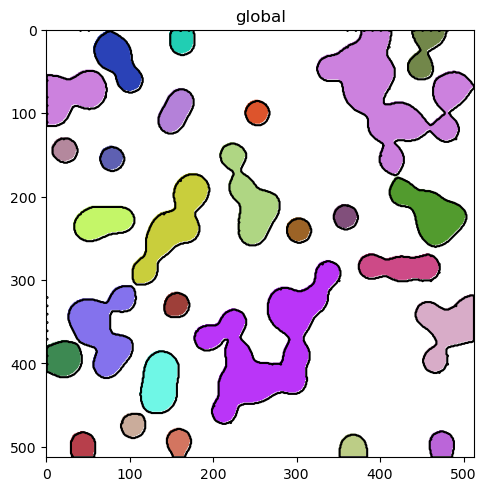

In [5]:
sdata.pl.render_labels().pl.render_shapes("vectorized", outline=True, fill_alpha=0).pl.show()

Sometimes an approximation of the polygons/multipolygons is enough for some certain use cases. Such conversion is available via the function `to_circles()`.

In [6]:
sdata["circles"] = to_circles(sdata["blobs_labels"])

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:987: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


INFO     Using matplotlib                                                                                          


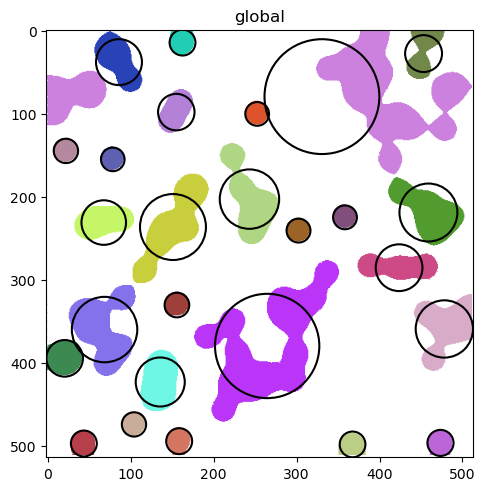

In [7]:
sdata.pl.render_labels().pl.render_shapes("circles", outline=True, fill_alpha=0).pl.show()

Note how in this case the large multipolygon on the top of the figure (shown also below) is approximated by a circle whose centroid is outside the multipolygon, because of the fact that it has 2 distant components. Except for this, we can see that the circles approximation for the other shapes is good.

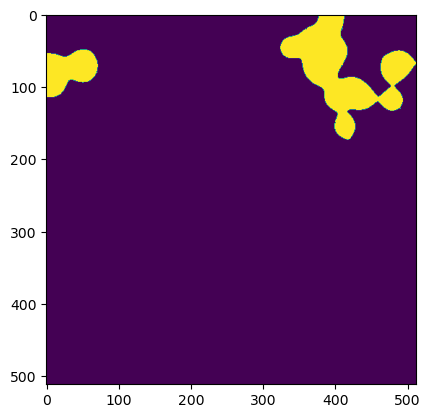

In [8]:
import matplotlib.pyplot as plt

plt.imshow(sdata["blobs_labels"] == 1)

## Rasterization

Rasterization consist in creating a 2D image representing geometries (polygons / multipolygons / points in this tutorial).

### Shapes rasterization

We want to transform the following polygons into images:

INFO     Using matplotlib                                                                                          


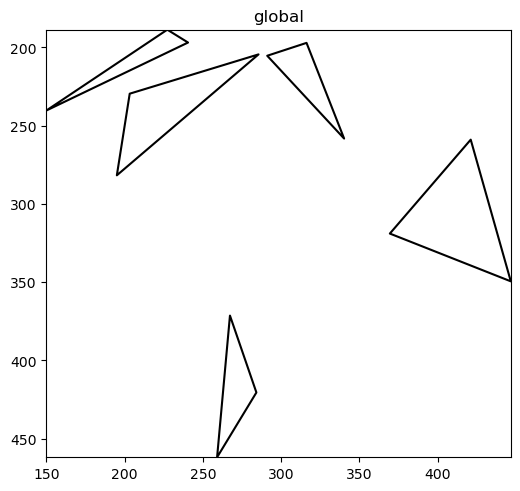

In [9]:
sdata.pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

Here, by default, we "count" the shapes. I.e., it will produce an image of shape `(1, y, x)` with zeros where there is no shape, ones where there is one shape, two if two shapes overlap, and so on.

In [10]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[0, 0],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    target_unit_to_pixels=1.0,
)

INFO     Using matplotlib                                                                                          


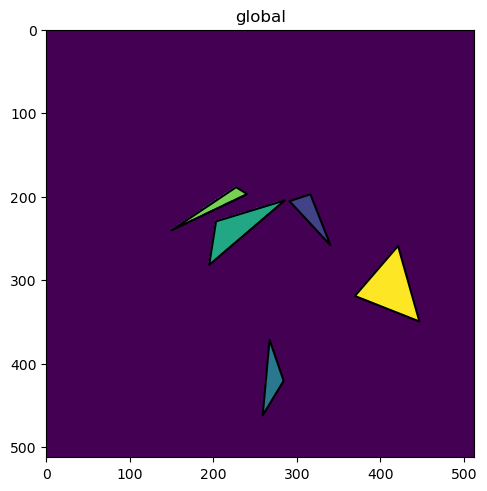

In [11]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

The argument `target_unit_to_pixels` is the ratio between the unit of the coordinate system and the resulting image size. Here, we set `target_unit_to_pixels=0.1`, which consequently divides by 10 the image size (and resolution):

In [12]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    target_unit_to_pixels=0.1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using matplotlib                                                                                          


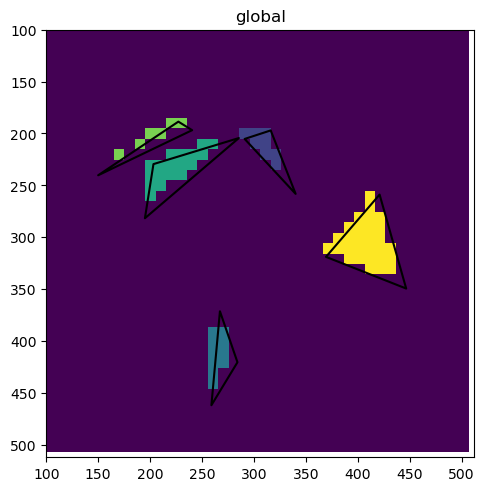

In [13]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

*Please note that in the above image the rasterized shapes show a pixel offset; this is a known bug that is tracked here: https://github.com/scverse/spatialdata/issues/165.*

With the rasterization below, we don't retain the ID of each shape. To have separated values for each shape, we can use `instance_key_as_default_value_key=True`. The first shape will be rasterized with ones, the second shape with 2, and so on.

Note that, in case two shapes overlap, only the first one is kept. If the shapes are highly overlapping, it is therefore recommended to use a different rasterization choice, shown later.

In [14]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using matplotlib                                                                                          


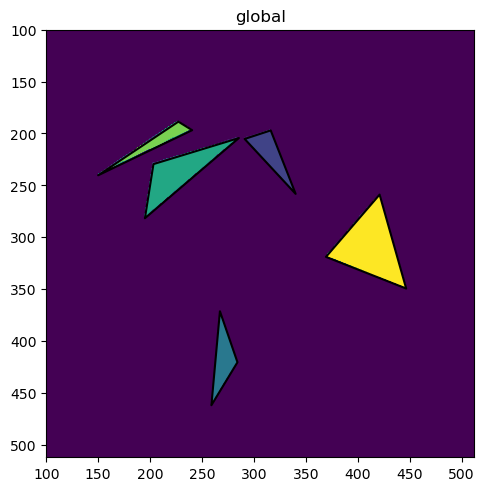

In [15]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

When shapes are highly overlapping, the previous rasterization will result in information lost. Therefore, we provide `return_single_channel=False` below to create an image of shape `(c, y, x)`, where `c` is the number of different shapes to be rasterized. This way, we ensure no information is lost, and each channel will correspond to one shape. 

Please consider that this increases the size of the returned object, it is therefore recommended to use this strategy when only a small number of shapes to rasterize is present (e.g. a few large anatomical annotations, as opposed to a large collection of cells). When instead large collection of shapes is to be rasterized, we recommend to call `rasterize()` multiple times, each time around a crop around the shape.

In [16]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    return_single_channel=False,
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using matplotlib                                                                                          


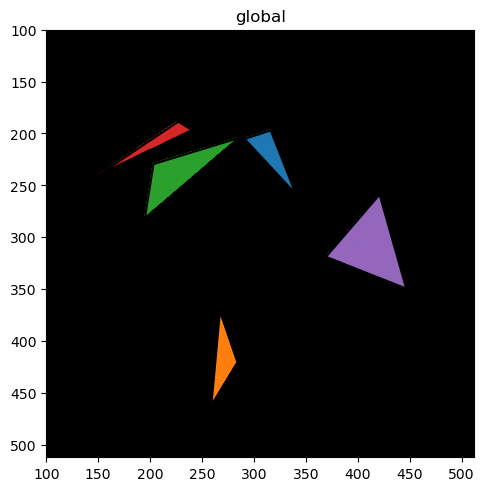

In [17]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

### Points rasterization

Points, for instance transcripts, can also be rasterized.

A simple case is to count the transcripts:

In [18]:
sdata["rasterized"] = rasterize(
    sdata["blobs_points"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    value_key="genes",
    target_coordinate_system="global",
    target_unit_to_pixels=0.3,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Each pixel intensity represents the number of transcripts at this specific location. Here, the image have a shape `(1, y, x)`, i.e. all points are rasterized into one single channel.

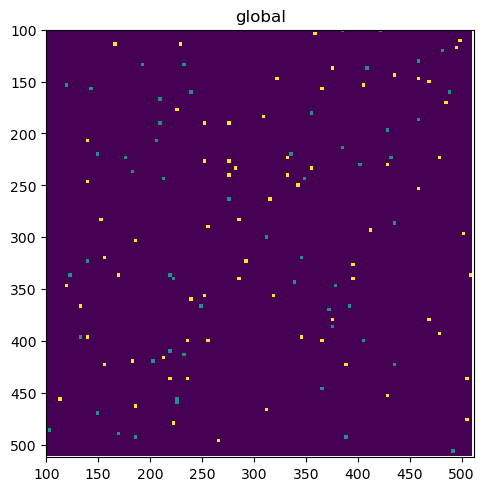

In [19]:
sdata.pl.render_images("rasterized").pl.show()

It's also possible to rasterize points that are grouped into different categories. For instance, below we rasterize transcripts for each gene.
For that, we provided `value_key="genes"` to denote that the column `"genes"` from `sdata["blobs_points"]` contains the genes names. It will output an image of shape `(c, y, x)`, where `c` is the number of different genes.

In [20]:
sdata["rasterized"] = rasterize(
    sdata["blobs_points"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    value_key="genes",
    return_single_channel=False,
    target_coordinate_system="global",
    target_unit_to_pixels=0.3,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


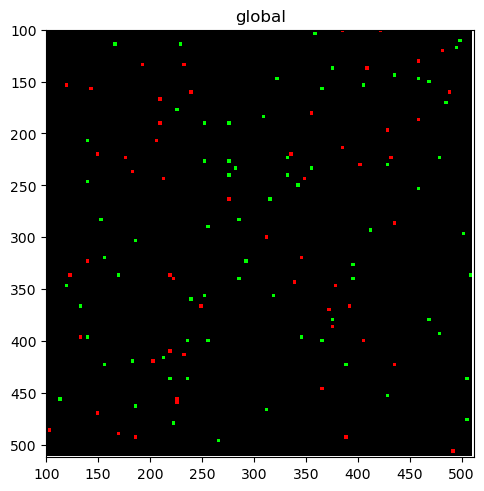

In [21]:
sdata.pl.render_images("rasterized").pl.show()

## Rasterization of binned data

In addition to `rasterize()`, we developed a specialized function to cover the case in which grid-like bins data needs to be rasterized.

For example, as explained thoroughly in the [Visium HD example notebook](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/technology_visium_hd.html), Visium HD data is represented as a collection of ~10 million vector geometries, each annotated by a sparse gene expression vector of length 20000 (i.e. together, the gene expression is represented as a 10000000 x 20000 sparse matrix). Crucially, the Visium HD geometries are arranged in a regular grid, we call such data *binned data*.

For binned data, we could represent each bin as a single pixel, resulting in a compact, convenient representation. This is what the `rasterize_bins()` function enables.

The `rasterize_bins()` function also addresses the two following challenges:
1. in the Visium HD example above, the data is too big and the size of the rasterized output would be around ~180 GB! For this reason `rasterize_bins()` returns a lazy `xarray.DataArray` object that can be accessed channel-wise performantly (but please pay attention not to call `.compute()` on the whole object).
2. in the Visium HD dataset the grid onto which the bins are arranged is not axis-aligned with respect to the xy axes. The `rasterize_bins()` function takes into account for this by requiring to pass as argument both the coordinates of the centroids of the bins, and the row/column indices of the bins. Then it computes an affine transformation that aligns the rasterized bins with the original data.

Let's see this with an example.

### Creating some example binned data

SpatialData object
├── Shapes
│     └── 'grid': GeoDataFrame shape: (20, 1) (2D shapes)
└── Tables
      └── 'annotation': AnnData (20, 10000)
with coordinate systems:
    ▸ 'global', with elements:
        grid (Shapes)
INFO     Using matplotlib                                                                                          


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/models/models.py:987: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


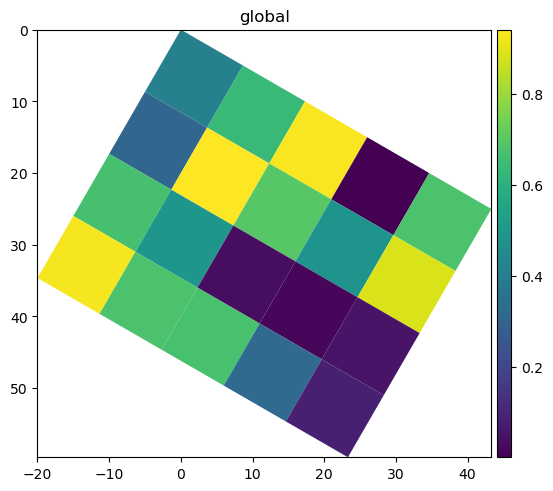

In [22]:
import geopandas as gpd
import numpy as np
import pandas as pd
import spatialdata_plot
from anndata import AnnData
from shapely.affinity import affine_transform
from shapely.geometry import box
from spatialdata import SpatialData, transform
from spatialdata.models import ShapesModel, TableModel
from spatialdata.transformations import Affine

# Step 1: Create a 4x5 grid of squares
rows, cols = 4, 5
square_size = 10
squares = []
row_indices = []
col_indices = []

for row in range(rows):
    for col in range(cols):
        minx, miny = col * square_size, row * square_size
        maxx, maxy = minx + square_size, miny + square_size
        squares.append(box(minx, miny, maxx, maxy))
        row_indices.append(row)
        col_indices.append(col)

# Step 2: Define an affine matrix for a 30-degree rotation
angle = np.pi / 6  # 30 degrees in radians
cos_angle = np.cos(angle)
sin_angle = np.sin(angle)
affine = Affine(
    [[cos_angle, -sin_angle, 0], [sin_angle, cos_angle, 0], [0, 0, 1]], input_axes=("x", "y"), output_axes=("x", "y")
)

# Step 3: Put these squares into a GeoPandas GeoDataFrame
gdf = ShapesModel.parse(gpd.GeoDataFrame({"geometry": squares}), transformations={"global": affine})

# Step 4: rotate the data
gdf = transform(gdf, to_coordinate_system="global")

# Step 5: add an annotation matrix
TABLE_NAME = "annotation"
SHAPES_NAME = "grid"
REGION_KEY = "region"
INSTANCE_KEY = "instance_id"

n = len(gdf)
n_features = 10000

# the row and col indices are required by rasterize_bins()
obs = pd.DataFrame(data={REGION_KEY: SHAPES_NAME, INSTANCE_KEY: range(n), "row": row_indices, "col": col_indices})
var = pd.DataFrame(index=[f"feature_{i}" for i in range(n_features)])

adata = TableModel.parse(
    AnnData(np.random.rand(n, n_features), obs=obs, var=var),
    region=SHAPES_NAME,
    region_key=REGION_KEY,
    instance_key=INSTANCE_KEY,
)

# Step 6: bundle everything in a SpatialData object

sdata = SpatialData(shapes={SHAPES_NAME: gdf}, tables={TABLE_NAME: adata})
print(sdata)

# Display the rotated grid
c = 333
sdata.pl.render_shapes(SHAPES_NAME, color=f"feature_{c}").pl.show()

### Calling `rasterize_bins()`

In [23]:
%%time
from spatialdata import rasterize_bins

rasterized = rasterize_bins(sdata, bins=SHAPES_NAME, table_name=TABLE_NAME, col_key="col", row_key="row")
rasterized

CPU times: user 18.9 ms, sys: 1.48 ms, total: 20.4 ms
Wall time: 20 ms


<xarray.DataArray 'image' (c: 10000, y: 4, x: 5)> Size: 800kB
dask.array<channel_rasterization, shape=(10000, 4, 5), dtype=uint32, chunksize=(1, 4, 5), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) object 80kB 'feature_0' 'feature_1' ... 'feature_9999'
  * y        (y) float64 32B 0.5 1.5 2.5 3.5
  * x        (x) float64 40B 0.5 1.5 2.5 3.5 4.5
Attributes:
    transform:  {'global': Sequence \n    Sequence \n        Affine (x, y -> ...

In [24]:
sdata["rasterized"] = rasterized

INFO     Using matplotlib                                                                                          


(59.64101615137754, 0.0)

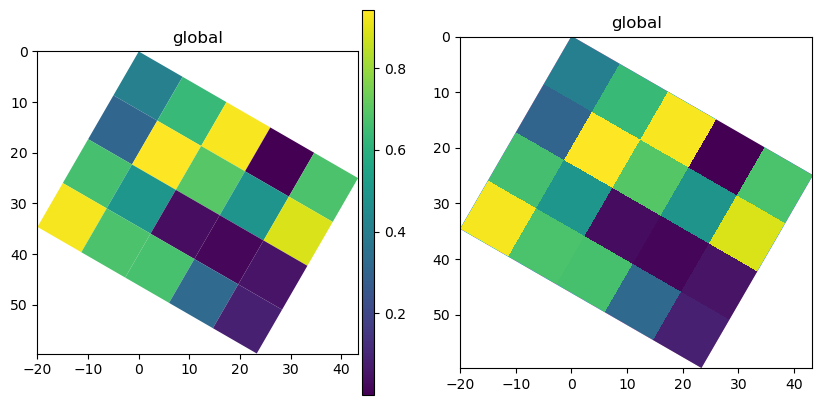

In [25]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 2, figsize=(10, 5))[1]

sdata.pl.render_shapes(SHAPES_NAME, color=f"feature_{c}").pl.show(ax=axes[0])
sdata.pl.render_images("rasterized", channel=f"feature_{c}").pl.show(ax=axes[1])
# let's manually fix the xlim and ylim of the second plot, whose computation is unfortunately affected by this bug:
# https://github.com/scverse/spatialdata/issues/165
# in short, there is an imprecision of half-pixel when computing the extent, but in this case the pixels are large
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

The plots above show that the rasterized data align with the original bins (squares). 

Internally, the data is represented as a regular image.

In [26]:
sdata["rasterized"].sel(c=f"feature_{c}").compute().to_numpy()

array([[4.06866126e-01, 6.33799871e-01, 9.32282155e-01, 1.19775175e-04,
        6.77130171e-01],
       [3.08218727e-01, 9.42287616e-01, 6.95059724e-01, 4.88281475e-01,
        8.90235436e-01],
       [6.63613912e-01, 4.95334682e-01, 3.08604559e-02, 1.70584118e-02,
        5.00584115e-02],
       [9.31242450e-01, 6.76026036e-01, 6.68190697e-01, 3.23855542e-01,
        8.27306899e-02]])

The function `rasterize_bins()` inferred the required alignment that was used in the plot above. Here is how to access the coordinate transformation.

In [27]:
from spatialdata.transformations import get_transformation

get_transformation(sdata["rasterized"], to_coordinate_system="global")

Sequence 
    Sequence 
        Affine (x, y -> x, y)
            [ 8.66025404 -5.          1.83012702]
            [5.         8.66025404 6.83012702]
            [0. 0. 1.]
    Identity 